In [1]:
import fastf1
from fastf1 import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
plt.style.use('dark_background')


In [2]:
from fastf1.utils import delta_time
import fastf1.plotting

## Data

In [3]:
session = fastf1.get_session(2025,'Imola','Race')
session.load(laps=True, weather=True, telemetry=True)

req         WARNING 	DEFAULT CACHE ENABLED! (2.06 GB) C:\Users\Sanket\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to ca

## Practice Analysis

## Qualifying Analysis

In [5]:
q1,q2,q3 = session.laps.split_qualifying_sessions()
q1 = q1.pick_accurate()
q2 = q2.pick_accurate()
q3 = q3.pick_accurate()

### P1,P2 Comparison

In [6]:
ver = q3.pick_driver('VER').pick_fastest().get_telemetry(frequency=20).add_distance()
pia = q3.pick_driver('PIA').pick_fastest().get_telemetry(frequency=20).add_distance()

In [7]:
delta_time, ref_tel, compare_tel = utils.delta_time(q3.pick_driver('PIA').pick_fastest(), q3.pick_driver('VER').pick_fastest())

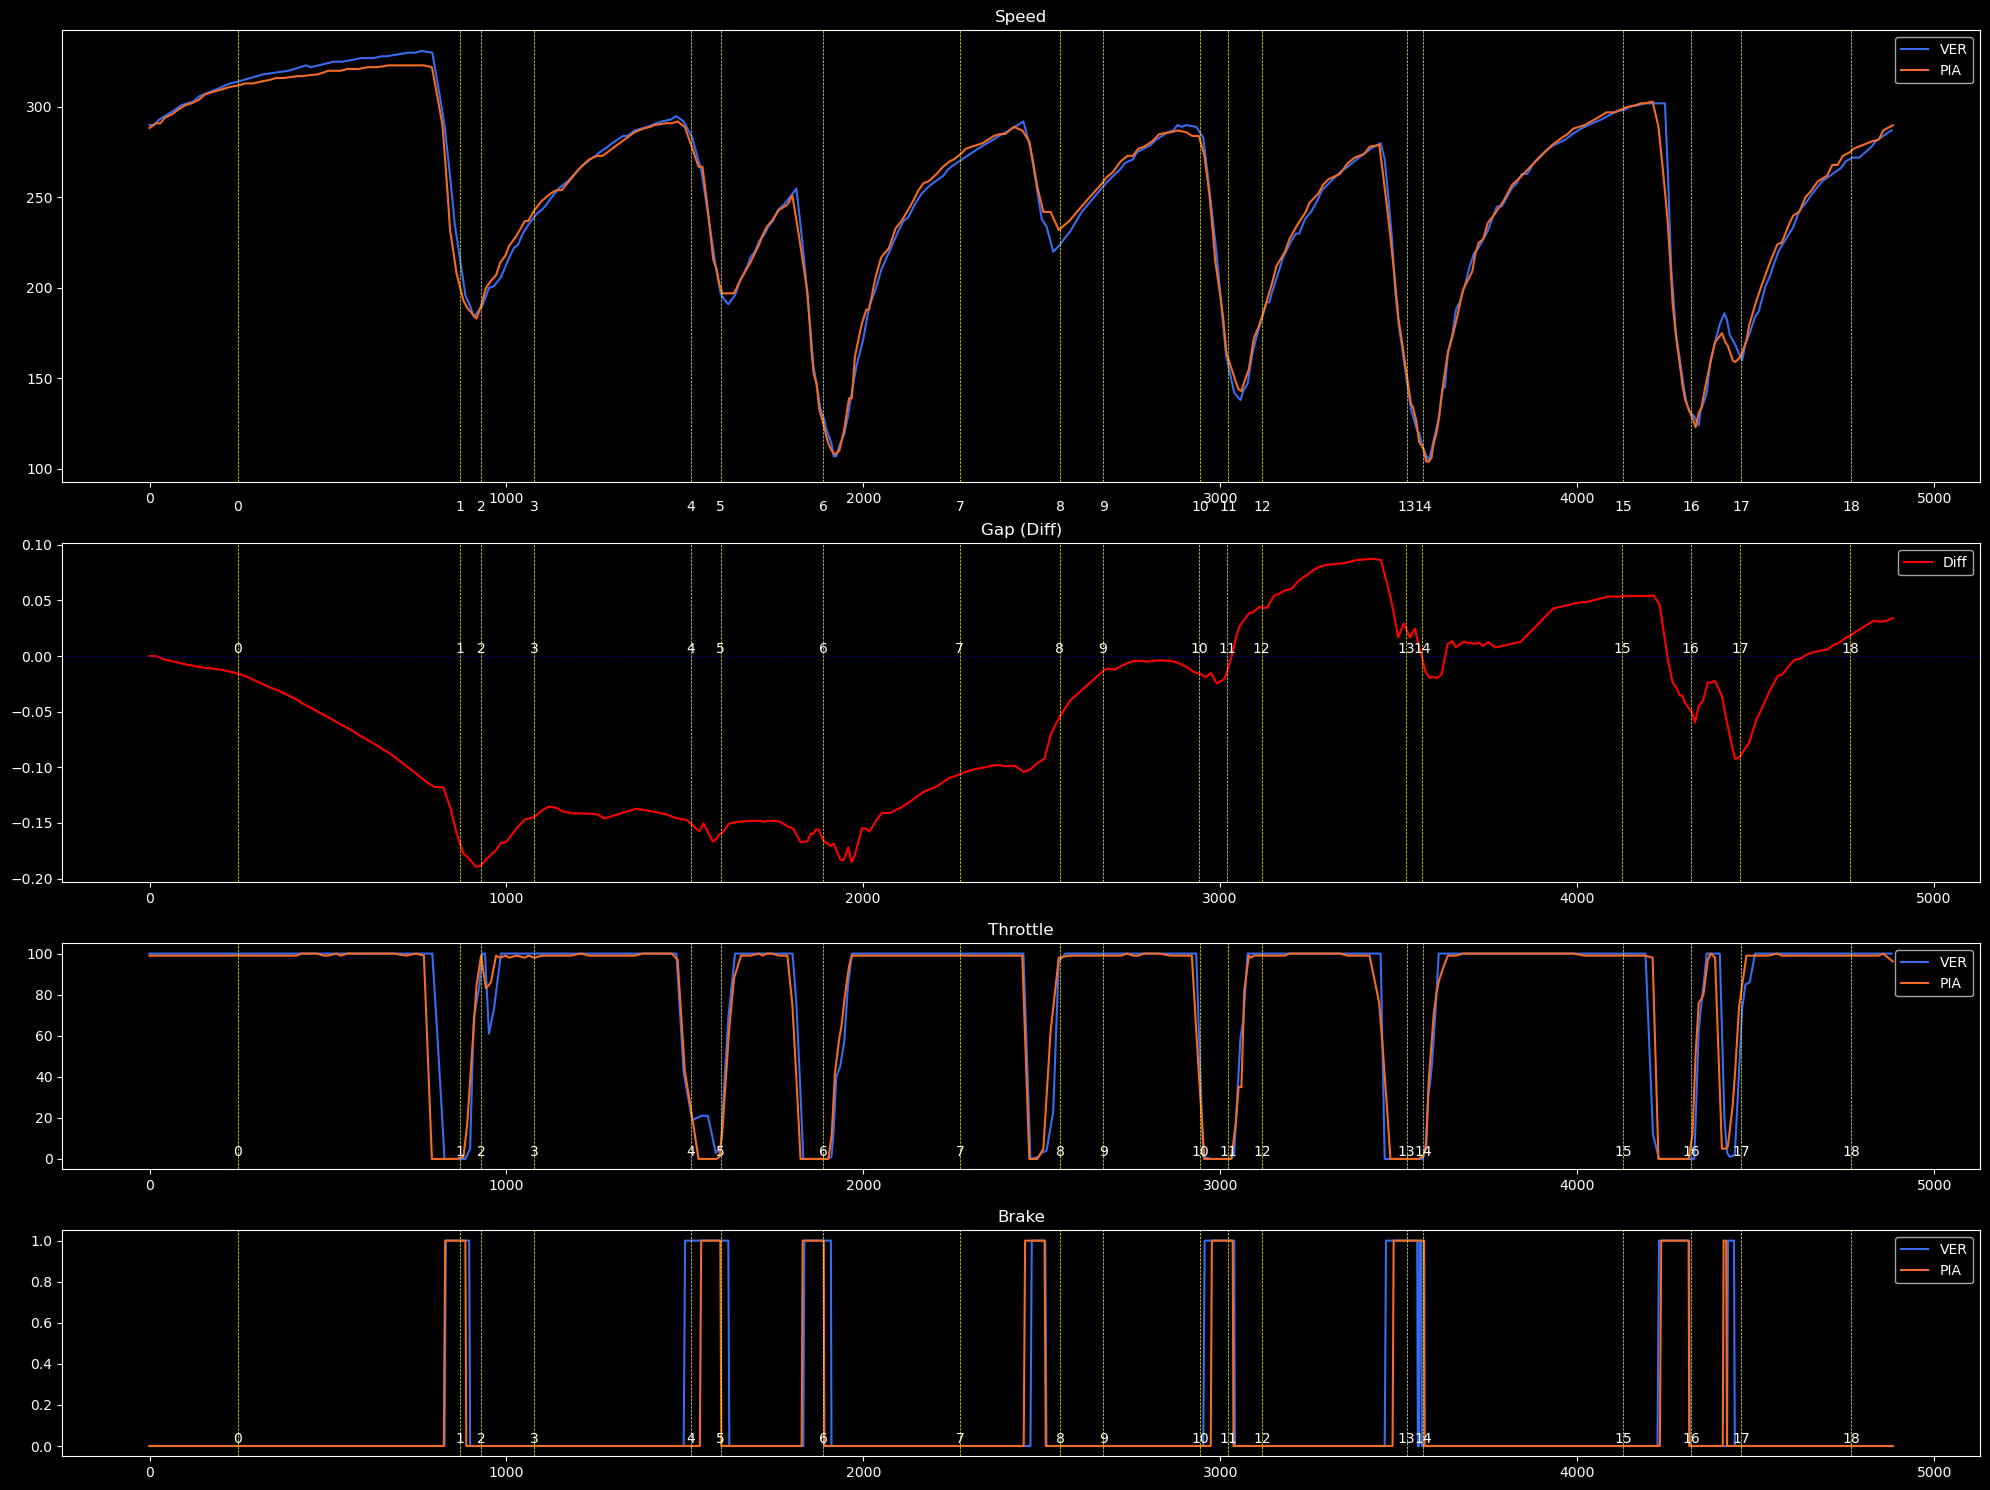

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(4, 1, height_ratios=[1, 0.75, 0.5, 0.5])  # Define grid with different heights


# Speed Plot
ax0 = fig.add_subplot(gs[0])
ax0.plot(ver['Distance'], ver['Speed'], label='VER', color='#396bf0')
ax0.plot(pia['Distance'], pia['Speed'], label='PIA', color='#f26c28')
for corner_index in range(len(session.get_circuit_info().corners)):
    ax0.axvline(x=session.get_circuit_info().corners['Distance'][corner_index], color='yellow', linestyle='--', linewidth=0.5)
    ax0.text(session.get_circuit_info().corners['Distance'][corner_index], 75, f'{corner_index}', ha='center', va='bottom')
ax0.legend()
ax0.set_title("Speed")

# Gap (Diff) Plot
ax1 = fig.add_subplot(gs[1])
ax1.plot(ref_tel['Distance'],delta_time, label='Diff', color='red')
ax1.axhline(y=0, color='blue', linestyle='dotted', linewidth=0.5)
for corner_index in range(len(session.get_circuit_info().corners)):
    ax1.axvline(x=session.get_circuit_info().corners['Distance'][corner_index], color='yellow', linestyle='--', linewidth=0.5)
    ax1.text(session.get_circuit_info().corners['Distance'][corner_index], 0, f'{corner_index}', ha='center', va='bottom')
ax1.legend()
ax1.set_title("Gap (Diff)")

# Throttle Plot
ax2 = fig.add_subplot(gs[2])
ax2.plot(ver['Distance'], ver['Throttle'], label='VER', color='#396bf0')
ax2.plot(pia['Distance'], pia['Throttle'], label='PIA', color='#f26c28')
for corner_index in range(len(session.get_circuit_info().corners)):
    ax2.axvline(x=session.get_circuit_info().corners['Distance'][corner_index], color='yellow', linestyle='--', linewidth=0.5)
    ax2.text(session.get_circuit_info().corners['Distance'][corner_index], 0, f'{corner_index}', ha='center', va='bottom')
ax2.legend()
ax2.set_title("Throttle")

# Brake Plot
ax3 = fig.add_subplot(gs[3])
ax3.plot(ver['Distance'], ver['Brake'], label='VER', color='#396bf0')
ax3.plot(pia['Distance'], pia['Brake'], label='PIA', color='#f26c28')
for corner_index in range(len(session.get_circuit_info().corners)):
    ax3.axvline(x=session.get_circuit_info().corners['Distance'][corner_index], color='yellow', linestyle='--', linewidth=0.5)
    ax3.text(session.get_circuit_info().corners['Distance'][corner_index], 0, f'{corner_index}', ha='center', va='bottom')
ax3.legend()
ax3.set_title("Brake")

plt.tight_layout()
plt.savefig(f'Projects\F1_Analysis\Analysis_Images\{format(session.session_info['StartDate'],'%Y')}_{session.session_info['Meeting']['Location']}_{session.session_info['Type']}_P1P2Comparison')

plt.show()

### Car Setups

In [8]:
car_setups = []

In [9]:
for i in session.drivers:
    try:
        car_setups.append([i,session.get_driver(i)['TeamName'],session.laps.pick_drivers(i).pick_fastest().get_telemetry().Speed.mean(),session.laps.pick_drivers(i).pick_fastest().get_telemetry().Speed.max()])
    except:
        pass

In [10]:
car_setups = pd.DataFrame(car_setups,columns=['Driver','Team','MeanSpeed','TopSpeed'])

In [11]:
car_setups

,Driver,Team,MeanSpeed,TopSpeed
0,81,McLaren,232.744436,323.0
1,1,Red Bull Racing,234.754174,331.0
2,63,Mercedes,235.073349,330.0
3,4,McLaren,234.533149,325.0
4,14,Aston Martin,233.766023,330.0
5,55,Williams,235.467220,329.0
6,23,Williams,232.069229,327.0
7,18,Aston Martin,232.656341,328.0
8,6,Racing Bulls,234.772642,328.0
9,10,Alpine,232.490465,330.0


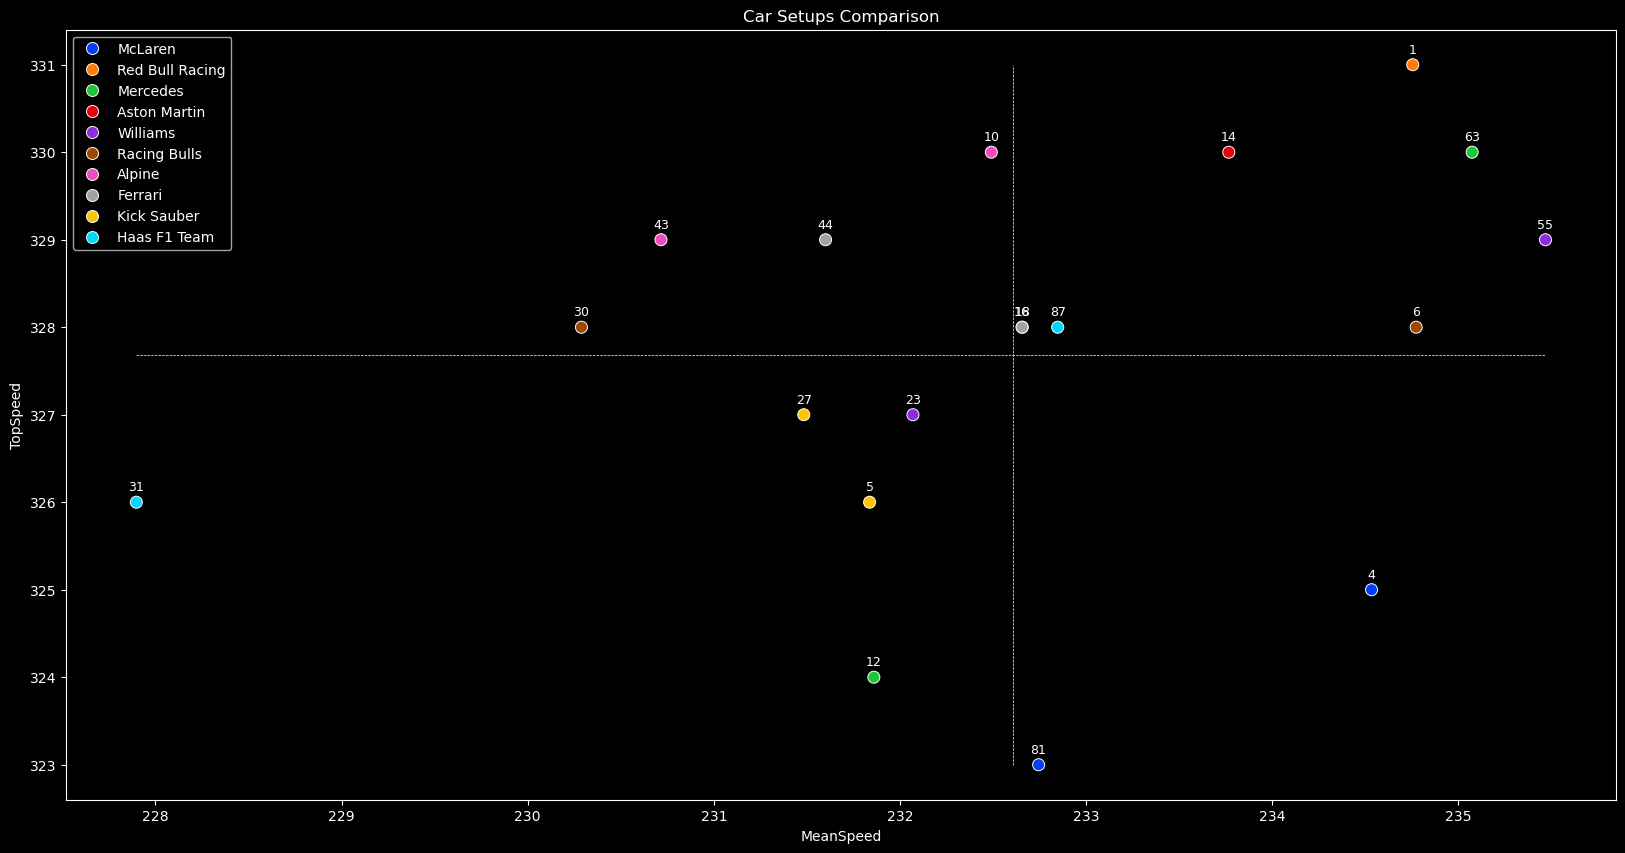

In [12]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=car_setups,x='MeanSpeed',y='TopSpeed',hue='Team',palette='bright',s=75)
plt.hlines(car_setups['TopSpeed'].mean(),xmin=car_setups['MeanSpeed'].min(),xmax=car_setups['MeanSpeed'].max(),linestyles='dashed',linewidth=0.5)
plt.vlines(car_setups['MeanSpeed'].mean(),ymin=car_setups['TopSpeed'].min(),ymax=car_setups['TopSpeed'].max(),linestyles='dashed',linewidth=0.5)

for _, row in car_setups.iterrows():
    plt.text(row['MeanSpeed'], row['TopSpeed']+0.1, row['Driver'], fontsize=9, ha='center', va='bottom')

plt.legend()
plt.title('Car Setups Comparison')
plt.savefig(f'{format(session.session_info['StartDate'],'%Y')}_{session.session_info['Meeting']['Location']}_{session.session_info['Type']}_CarSetups.png')

plt.show()

## Race Analysis

### LapTime Boxplots

In [5]:
session.laps.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')

In [ ]:
data = pd.DataFrame(session.laps.pick_accurate())[['Driver', 'LapNumber','Compound','LapTime']].sort_values()

In [13]:
data['LapTime'] = data['LapTime'].dt.total_seconds()

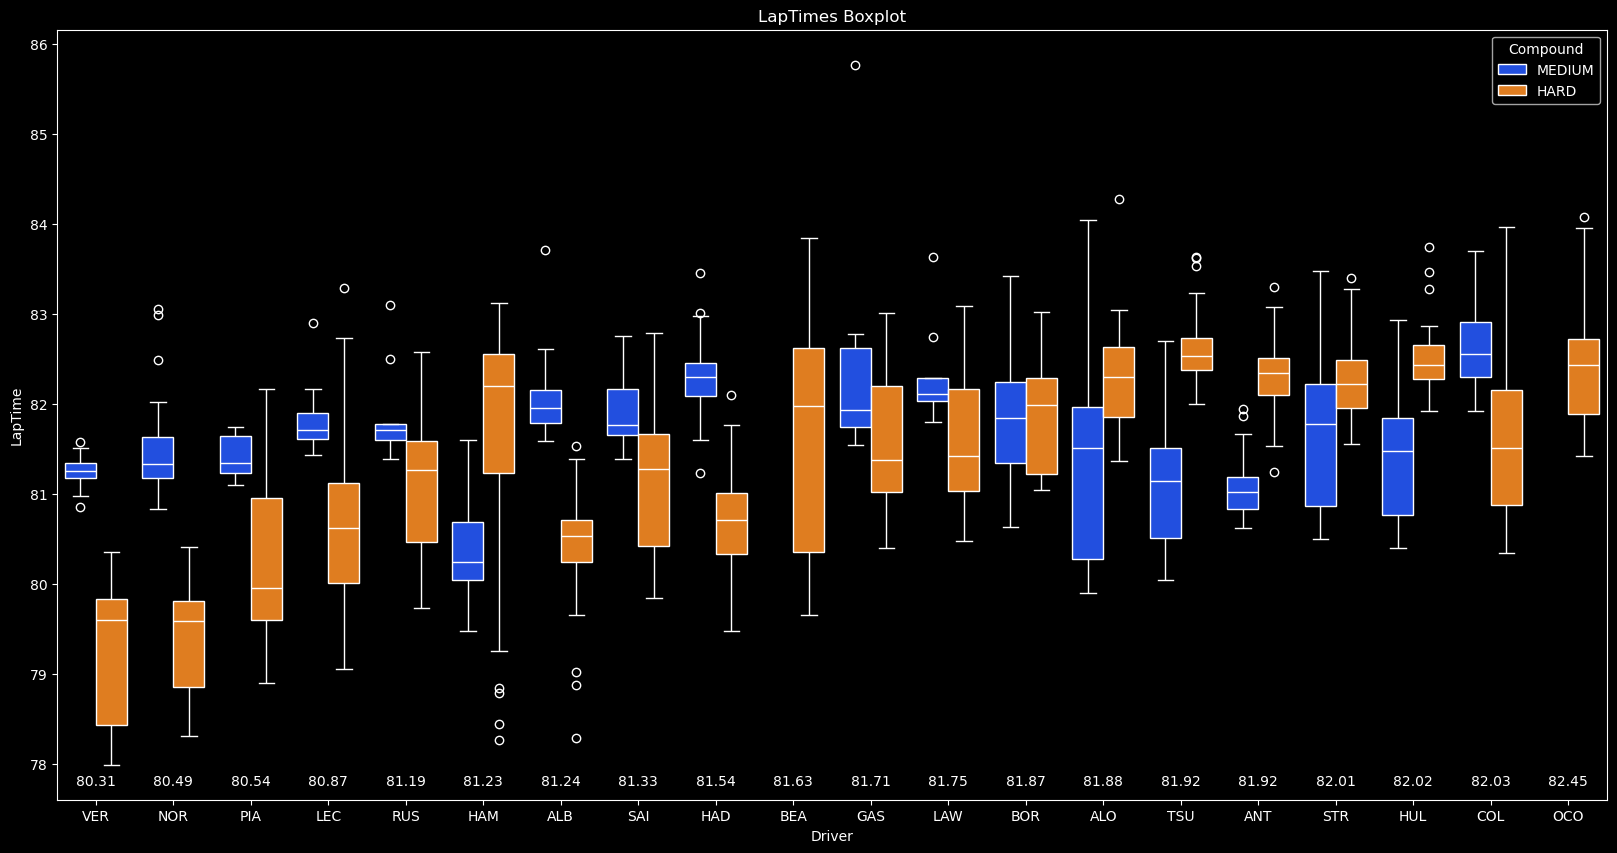

In [123]:
driver_order = data.groupby('Driver')['LapTime'].mean().sort_values().index
mean_lap_times = data.groupby('Driver')['LapTime'].mean()

plt.figure(figsize=(20,10))
sns.set_palette("bright")
sns.boxplot(data=data,x='Driver',y='LapTime',hue='Compound',order=driver_order,linecolor='white')

for i, driver in enumerate(driver_order):
    plt.text(i,77.72, f"{mean_lap_times[driver]:.2f}", 
             ha='center', va='bottom', fontsize=10, color='white')
    
plt.title('LapTimes Boxplot')
plt.savefig(f'{format(session.session_info['StartDate'],'%Y')}_{session.session_info['Meeting']['Location']}_{session.session_info['Type']}_LapTimes')

### 0 - 100 acceleration

In [ ]:
zero_hundred = []

for i in session.drivers:
    tel = session.laps.pick_driver(i).pick_lap(1).get_telemetry()
    lap_time_sec = tel[tel['Distance'] < 40]['Time'][-2:-1].dt.total_seconds().values
    if len(lap_time_sec) > 0:
        zero_hundred.append([i, lap_time_sec[0]])
    else:
        zero_hundred.append([i, None])

zero_hundred = pd.DataFrame(zero_hundred,columns=['Driver','Acceleration']).sort_values('Acceleration')

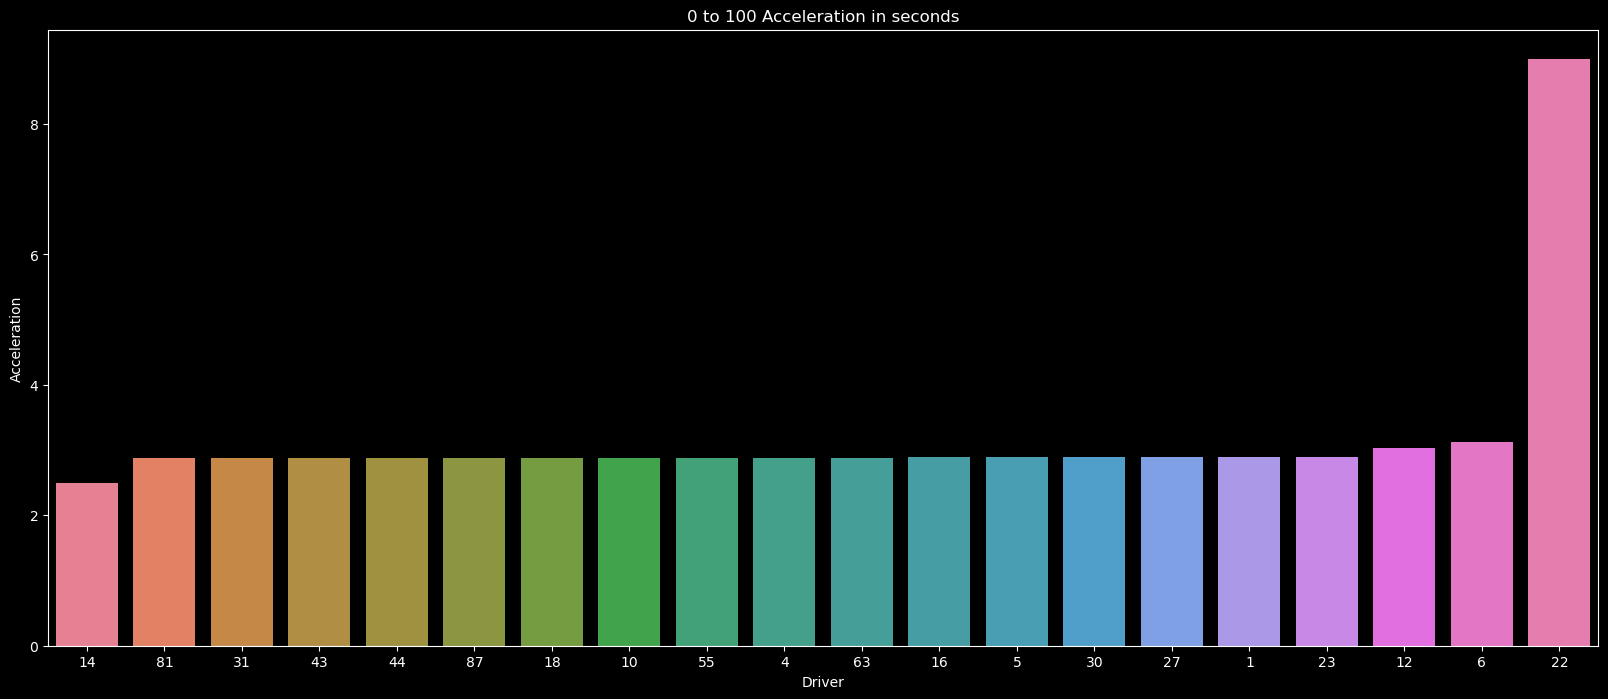

In [126]:
# Sort by Acceleration (ascending)
plt.figure(figsize=(20,8))
sns.barplot(data=zero_hundred, x='Driver', y='Acceleration',hue='Driver')


plt.title('0 to 100 Acceleration in seconds')

plt.savefig(f'{format(session.session_info['StartDate'],'%Y')}_{session.session_info['Meeting']['Location']}_{session.session_info['Type']}_ZeroHundred_Comparison')